## ECE-253 HW3

In [46]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

### Problem 1. Canny Edge Detection

In [3]:
# Input: grayscale image - im, threshold t_e
# return an edge image - edge

def CED(im, t_e):
    assert len(im.shape)<3, 'Image is not in grayscale'
    assert type(t_e) == int or type(t_e) == float, 'Threshold should be number'
    
    # Smoothing
    im = im/255
    k_mat = np.array([[2,4,5,4,2],[4,9,12,9,4],[5,12,15,12,5],[4,9,12,9,4],[2,4,5,4,2]])/159
    im_smooth = cv2.filter2D(im,-1,k_mat)
            
    # Finding Gradients
    im_grad = np.zeros(im_smooth.shape)
    im_edge = np.zeros(im_smooth.shape)
    k_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    k_y = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    x_grad = cv2.filter2D(im_smooth,-1,k_x)
    y_grad = cv2.filter2D(im_smooth,-1,k_y)
    im_grad = np.sqrt(x_grad**2+y_grad**2)
    x_grad = np.where(x_grad == 0,0.00001,x_grad) 
    im_edge =np.arctan2(y_grad,x_grad)*180/np.pi
    
    # Non-maximum Suppression
    edge_abs = np.absolute(im_edge)
    edge_round = np.zeros(edge_abs.shape)
    edge_round = np.where((edge_abs>22.5)&(edge_abs<=67.5),-45,edge_round)
    edge_round = np.where((edge_abs>67.5)&(edge_abs<=112.5),90,edge_round)
    edge_round = np.where((edge_abs>112.5)&(edge_abs<=157.5),45,edge_round)
    grad_pad = np.pad(im_grad,1,'symmetric')
    im_NSM = np.zeros(im_grad.shape)
    
    for i in range(1,grad_pad.shape[0]-1):
        for j in range(1,grad_pad.shape[1]-1):
            n_1 = 0;
            n_2 = 0;
            angle = edge_round[i-1,j-1]
            grad = grad_pad[i,j]
            if angle == 0:
                # Horizontal
                n_1 = grad_pad[i,j-1]
                n_2 = grad_pad[i,j+1]
            elif angle == -45:
                # -45 Degree
                n_1 = grad_pad[i-1,j-1]
                n_2 = grad_pad[i+1,j+1]
            elif angle == 45:
                # 45 Degree
                n_1 = grad_pad[i-1,j+1]
                n_2 = grad_pad[i+1,j-1]
            else:
                # Vertical
                n_1 = grad_pad[i-1,j]
                n_2 = grad_pad[i+1,j]
            if (grad>=n_1)&(grad>=n_2):
                im_NSM[i-1,j-1] = grad
                
    # Thresholding            
    im_thrsd = np.where(im_NSM<t_e,0,1)
    
    return im_grad,im_NSM,im_thrsd

In [4]:
geisel = cv2.imread('C://Users/10445/ECE-253/HW3_geisel.jpg',0)
im_grad,im_NSM,im_thrsd = CED(geisel,0.6)

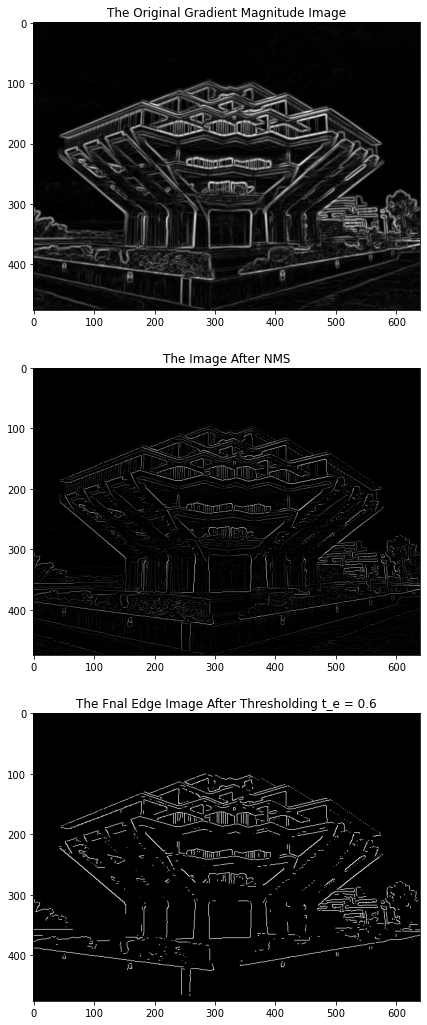

In [5]:
ref = plt.figure(figsize = (16,18))
ax0 = ref.add_subplot(3,1,1)
ax0.imshow(im_grad,cmap='gray')
ax0.title.set_text('The Original Gradient Magnitude Image')
ax1 = ref.add_subplot(3,1,2)
ax1.imshow(im_NSM,cmap='gray')
ax1.title.set_text('The Image After NMS')
ax2 = ref.add_subplot(3,1,3)
ax2.imshow(im_thrsd,cmap='gray')
ax2.title.set_text('The Fnal Edge Image After Thresholding t_e = 0.6')

### Problem 2. Butterworth Notch Reject Filtering in Frequency Domain

#### Part (i)

In [92]:
def BNRfilter(K,n,D_0,u_k,v_k):
    
    x_axis = np.linspace(-256,255,512)
    y_axis = np.linspace(-256,255,512)
    [u,v] = np.meshgrid(x_axis,y_axis)
    H = np.ones((512,512))
    for i in range(K):
        D_k = np.sqrt((u-u_k[i])**2+(v-v_k[i])**2)
        D_neg_k = np.sqrt((u+u_k[i])**2+(v+v_k[i])**2)

        H *= 1/((1+(D_0/D_k)**(2*n))*(1+(D_0/D_neg_k)**(2*n)))
              
    return H

<ipython-input-92-85d875431839>:11: RuntimeWarning: divide by zero encountered in true_divide
  H *= 1/((1+(D_0/D_k)**(2*n))*(1+(D_0/D_neg_k)**(2*n)))


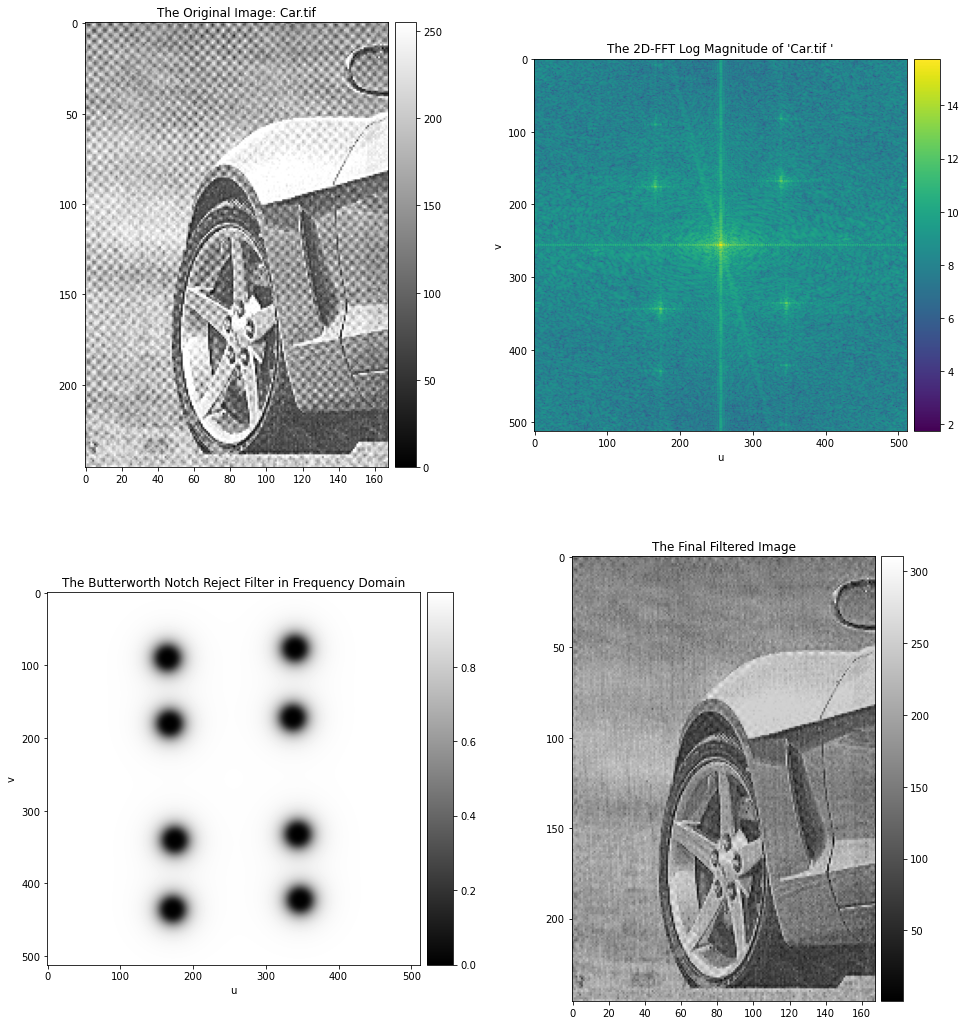

In [142]:
im = cv2.imread('C://Users/10445/ECE-253/Car.tif',0)
pad_length = int((512 - im.shape[0])/2)
pad_width = int(((512 - im.shape[1])/2))
im_pad = np.pad(im,((pad_length,),(pad_width,)),'constant')
im_fft = np.fft.fft2(im_pad)
im_shift = np.fft.fftshift(im_fft)
log_mag = np.log(abs(im_shift))

# BNR filter 
u_k = np.array([165,168,175,172])-256
v_k = np.array([90,180,340,435])-256
K = 4
n = 2
D_0 = 20
H = BNRfilter(K,n,D_0,u_k,v_k)

# Generate Filtered Image
filt_shift = np.fft.ifftshift(im_shift*H)
im_ifft = np.fft.ifft2(filt_shift)
im_filt = np.abs(im_ifft[pad_length:512-pad_length,pad_width:512-pad_width])

# Generate Plots
fig = plt.figure(figsize = (16,18))

ax0 =fig.add_subplot(2,2,1)
im0 = ax0.imshow(im,cmap='gray')
ax0_divider = make_axes_locatable(ax0)
cax0 = ax0_divider.append_axes("right", size="7%", pad="2%")
cb0 = fig.colorbar(im0, cax=cax0, orientation="vertical")
ax0.title.set_text('The Original Image: Car.tif')

ax1 = fig.add_subplot(2,2,2)
im1 = ax1.imshow(log_mag)
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cb1 = fig.colorbar(im1, cax=cax1, orientation="vertical")
ax1.set_xlabel('u')
ax1.set_ylabel('v')
ax1.title.set_text('The 2D-FFT Log Magnitude of \'Car.tif \'')

ax2 = fig.add_subplot(2,2,3)
im2 = ax2.imshow(H,cmap='gray')
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("right", size="7%", pad="2%")
cb2 = fig.colorbar(im2, cax=cax2, orientation="vertical")
ax2.set_xlabel('u')
ax2.set_ylabel('v')
ax2.title.set_text('The Butterworth Notch Reject Filter in Frequency Domain')

ax3 = fig.add_subplot(2,2,4)
im3 = ax3.imshow(im_filt,cmap='gray')
ax3_divider = make_axes_locatable(ax3)
cax3 = ax3_divider.append_axes("right", size="7%", pad="2%")
cb3 = fig.colorbar(im3, cax=cax3, orientation="vertical")
ax3.title.set_text('The Final Filtered Image')

#### Part (ii)

<ipython-input-92-85d875431839>:11: RuntimeWarning: divide by zero encountered in true_divide
  H *= 1/((1+(D_0/D_k)**(2*n))*(1+(D_0/D_neg_k)**(2*n)))


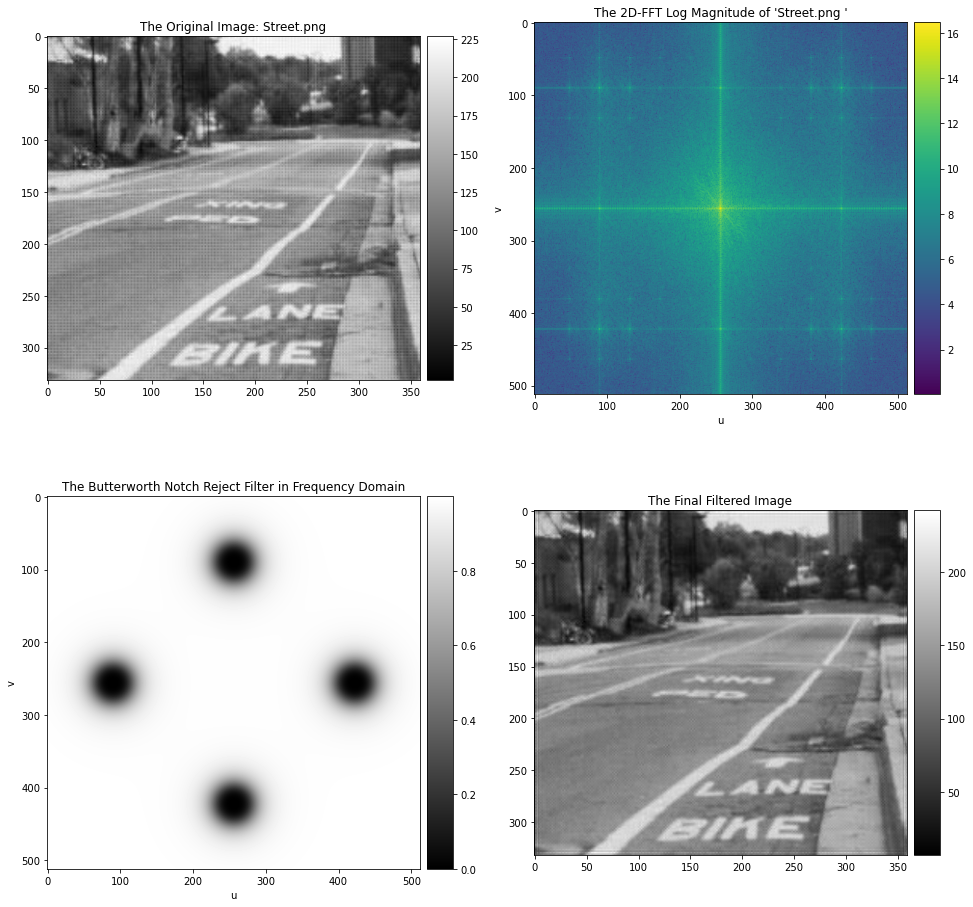

In [143]:
im = cv2.imread('C://Users/10445/ECE-253/Street.png',0)
pad_length = (512 - im.shape[0])//2
pad_width = (512 - im.shape[1])//2
im_pad = np.pad(im,((pad_length,),(pad_width+1,)),'constant')
im_fft = np.fft.fft2(im_pad)
im_shift = np.fft.fftshift(im_fft)
log_mag = np.log(abs(im_shift))

# BNR filter 
u_k = np.array([90,256])-256
v_k = np.array([256,90])-256
K = 2
n = 2
D_0 = 30
H = BNRfilter(K,n,D_0,u_k,v_k)

# Generate Filtered Image
filt_shift = np.fft.ifftshift(im_shift[:,:-1]*H)
im_ifft = np.fft.ifft2(filt_shift)
im_filt = np.abs(im_ifft[pad_length:512-pad_length,pad_width:511-pad_width])

# Generate Plots
fig = plt.figure(figsize = (16,16))
ax0 =fig.add_subplot(2,2,1)
im0 = ax0.imshow(im,cmap='gray')
ax0_divider = make_axes_locatable(ax0)
cax0 = ax0_divider.append_axes("right", size="7%", pad="2%")
cb0 = fig.colorbar(im0, cax=cax0, orientation="vertical")
ax0.title.set_text('The Original Image: Street.png')

ax1 = fig.add_subplot(2,2,2)
im1 = ax1.imshow(log_mag)
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cb1 = fig.colorbar(im1, cax=cax1, orientation="vertical")
ax1.title.set_text('The 2D-FFT Log Magnitude of \'Street.png \'')
ax1.set_xlabel('u')
ax1.set_ylabel('v')

ax2 = fig.add_subplot(2,2,3)
im2 = ax2.imshow(H,cmap='gray')
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("right", size="7%", pad="2%")
cb2 = fig.colorbar(im2, cax=cax2, orientation="vertical")
ax2.set_xlabel('u')
ax2.set_ylabel('v')
ax2.title.set_text('The Butterworth Notch Reject Filter in Frequency Domain')

ax3 = fig.add_subplot(2,2,4)
im3 = ax3.imshow(im_filt,cmap='gray')
ax3_divider = make_axes_locatable(ax3)
cax3 = ax3_divider.append_axes("right", size="7%", pad="2%")
cb3 = fig.colorbar(im3, cax=cax3, orientation="vertical")
ax3.title.set_text('The Final Filtered Image')